In [1]:
import pandas as pd
import numpy as np
import torch as t
import pickle as pkl
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv("data.csv")
data['text'] = data['text']\
  .str.replace('http://', '')\
  .str.replace('https://', '')\
  .str.replace('*', '')\
  .str.replace('/', ' ')\
  .str.replace(':', '')\
  .str.replace('www.', '')\
  .str.replace('.com', '')\
  .str.replace('.ly', '')\
  .str.replace('.live', '')\
  .str.replace('@', ' ')\
  .str.replace('  ', ' ')
data['X1'] = (data['title'] + '. ' + data['text']).astype(str)

ascii_only = lambda x: x.encode('ascii', 'ignore').decode('ascii')
data['X1'] = data['X1'].map(ascii_only)
data['X1'] = data['X1'].str.strip()
data.head(5)

<ipython-input-2-8d5430898c85>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['text'] = data['text']\
<ipython-input-2-8d5430898c85>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text']\


link                                              title  \
0      JLZlCZ0  ep 1 travelling through north east india  off ...   
1  i9E_Blai8vk        welcome to bali  travel vlog  priscilla lee   
2   r284c-q8oY  my solo trip to alaska  cruising from vancouve...   
3   Qmi-Xwq-ME   traveling to the happiest country in the world!!   
4  _lcOX55Ef70  solo in paro bhutan  tiger's nest visit  bhuta...   

                                         description category  \
0  Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nT...   travel   
1  Priscilla Lee\n45.6K subscribers\nSUBSCRIBE\n*...   travel   
2  Allison Anderson\n588K subscribers\nSUBSCRIBE\...   travel   
3  Yes Theory\n6.65M subscribers\nSUBSCRIBE\n*BLA...   travel   
4  Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nH...   travel   

             author    sub_count  \
0    Tanya Khanijow     671000.0   
1     Priscilla Lee     456000.0   
2  Allison Anderson     588000.0   
3        Yes Theory  665000000.0   
4    Tanya Khanijow     671000.0   

                                                text      views    likes  \
0  the journey to arunachal, north east india beg...        NaN      NaN   
1  disclaimer please do not ride elephants when v...  6243529.0  70325.0   
2  i spent 11 days cruising up the coast of alask...        NaN      NaN   
3  black friday drop out now seek-difort yes-theory         NaN      NaN   
4  here’s presenting the first part of the bhutan...  2576591.0  51798.0   

   comments                                                 X1  
0       NaN  ep 1 travelling through north east india  off ...  
1    3326.0  welcome to bali  travel vlog  priscilla lee. d...  
2       NaN  my solo trip to alaska  cruising from vancouve...  
3       NaN  traveling to the happiest country in the world...  
4    2895.0  solo in paro bhutan  tiger's nest visit  bhuta...

In [3]:
relevant = data.copy()
relevant = relevant[relevant['X1'].str.len() >= 8]
relevant = relevant[relevant['X1'].str.len() <= 300]

In [4]:
%pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from transformers import AlbertTokenizer, AlbertModel, AlbertForSequenceClassification

In [6]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

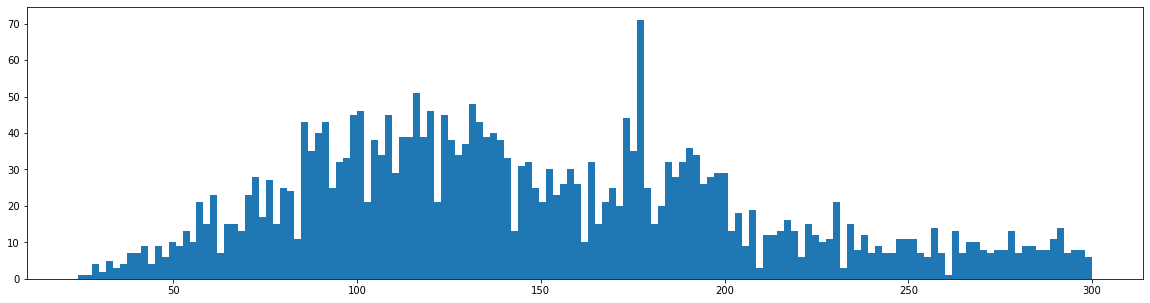

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.hist(relevant['X1'].str.len(), bins=int(relevant.shape[0] / 20))
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

X1_corpus = tokenizer(text=relevant.X1.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

Y1_target = LabelEncoder().fit_transform(relevant.category)

In [9]:
X1_input_ids = X1_corpus['input_ids']
X1_attention_mask = X1_corpus['attention_mask']

In [10]:
from sklearn.model_selection import train_test_split


test_size = 0.1
seed = 42

train_inputs_1, test_inputs_1, train_labels_1, test_labels_1 = \
            train_test_split(X1_input_ids, Y1_target, test_size=test_size, 
                             random_state=seed)
train_masks_1, test_masks_1, _, _ = train_test_split(X1_attention_mask, 
                                        Y1_target, test_size=test_size, 
                                        random_state=seed)

labels_1 = np.sort(np.unique(Y1_target))

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader

train_dataloader_1 = create_dataloaders(train_inputs_1, train_masks_1, 
                                      train_labels_1, batch_size)
test_dataloader_1 = create_dataloaders(test_inputs_1, test_masks_1, 
                                     test_labels_1, batch_size)

In [12]:
model_1 = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels = np.unique(train_labels_1).size)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [13]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

model_1.to(device)

Using GPU.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [14]:
from transformers import AdamW
optimizer = AdamW(model_1.parameters(),
                  lr=5e-5,
                  eps=1e-8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
total_steps = len(train_dataloader_1) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [16]:
from torch.nn.utils.clip_grad import clip_grad_norm_
from sklearn.metrics import accuracy_score, f1_score

def evaluate_outputs_loss(model, test_dataloader, device):
    model.eval()
    test_loss = []

    all_labels = []
    all_pred = []

    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks, labels = batch_labels)
        loss = outputs.loss
        test_loss.append(loss.item())
        batch_labels = batch_labels.cpu()
        
        pred = outputs.logits.argmax(dim=1).cpu().numpy()
        all_labels += list(batch_labels)
        all_pred += list(pred)
        
    return np.mean(test_loss), accuracy_score(all_labels, all_pred), f1_score(all_labels, all_pred, average='macro')

def train_outputs_loss(model, optimizer, scheduler, epochs,       
          train_dataloader, test_dataloader, device, clip_value=2):
    test_loss_1, test_acc_1, test_f1_1 = evaluate_outputs_loss(model, test_dataloader, device)
    print(f"Start of learning results:\nLoss: {test_loss_1}\nAccuracy: {test_acc_1}\nF1 Macro: {test_f1_1}")
    for epoch in range(epochs):
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch}"): 
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
            
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks, labels = batch_labels)           
            loss = outputs.loss
            
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

        test_loss_1, test_acc_1, test_f1_1 = evaluate_outputs_loss(model, test_dataloader, device)
        print(f"Epoch {epoch} results:\nLoss: {test_loss_1}\nAccuracy: {test_acc_1}\nF1 Macro: {test_f1_1}")
                
    return model

In [17]:
torch.cuda.empty_cache()

model_1 = train_outputs_loss(model_1, optimizer, scheduler, epochs, train_dataloader_1, test_dataloader_1, device, clip_value=2)

Start of learning results:
Loss: 1.3995197463679958
Accuracy: 0.2852233676975945
F1 Macro: 0.22171649422751766
-----


Epoch 0: 0it [00:00, ?it/s]

Epoch 0 results:
Loss: 0.30617458597329017
Accuracy: 0.9003436426116839
F1 Macro: 0.9034502636586054
-----


Epoch 1: 0it [00:00, ?it/s]

Epoch 1 results:
Loss: 0.11499731633277308
Accuracy: 0.979381443298969
F1 Macro: 0.9795192020746184
-----


Epoch 2: 0it [00:00, ?it/s]

Epoch 2 results:
Loss: 0.08255126396968104
Accuracy: 0.9862542955326461
F1 Macro: 0.9863030711871575
-----


Epoch 3: 0it [00:00, ?it/s]

Epoch 3 results:
Loss: 0.05962641427381518
Accuracy: 0.9896907216494846
F1 Macro: 0.9892893125447826
-----


Epoch 4: 0it [00:00, ?it/s]

Epoch 4 results:
Loss: 0.08139386920752381
Accuracy: 0.9862542955326461
F1 Macro: 0.9863030711871575


In [18]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
from bertviz import model_view

viz_text = "traveling to the happiest country in the world!!. black friday drop out now seek-difort yes-theory"  
viz_inputs = tokenizer.encode(viz_text, return_tensors='pt') 
outputs = model_1(viz_inputs.to(device), output_attentions=True)
attention = [t.cpu() for t in outputs.attentions]
tokens = tokenizer.convert_ids_to_tokens(viz_inputs[0])
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [35]:
viz_text_2 = "traveling to the happiest country in the world!!. black friday drop out now seek-difort yes-theory"  
viz_inputs_2 = tokenizer.encode(viz_text_2, return_tensors='pt', add_special_tokens=False) 
outputs_2 = model_1(viz_inputs_2.to(device), output_attentions=True)
attention_2 = [t.cpu() for t in outputs_2.attentions]
tokens_2 = tokenizer.convert_ids_to_tokens(viz_inputs_2[0])
model_view(attention_2, tokens_2)

<IPython.core.display.Javascript object>